In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

NotImplementedError: k-wave-python is currently unsupported on MacOS.

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

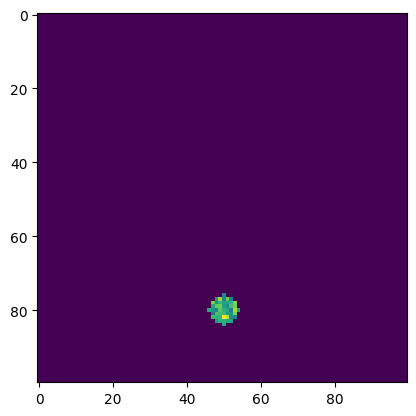

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
transducers = []
freqs = np.arange(1e6, 15e6, 0.5e6)
for i, freq in enumerate(freqs):
    transducers[i] = transducer.Planewave(max_frequency=freq,
                                          elements = 32, 
                                          width = 20e-3,
                                          height =  20e-3,
                                          sensor_sampling_scheme = 'not_centroid', 
                                          sweep = np.pi/3,
                                          ray_num = 32, 
                                          imaging_ndims = 2,
                                          focus_elevation = 20e-3)
    transducers[i].make_sensor_coords(test_phantom.baseline[0])


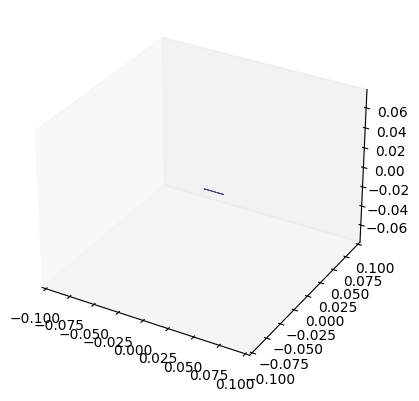

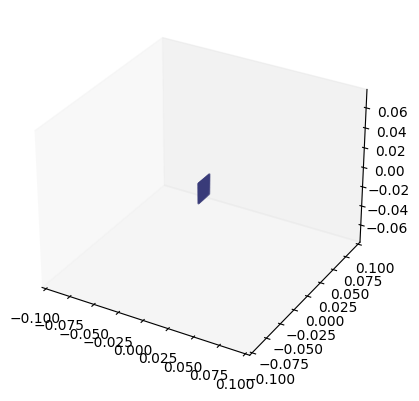

In [5]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
for i, t in enumerate(test_transducer_set.transducers):
    test_transducer_set.assign_pose(i, geometry.Transform([0, 0, 0], [0, 0, 0]))

In [6]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,60e-3,20e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/beam_width_test',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

In [10]:
test_experiment = experiment.Experiment.load('../experiment_files/beam_width_test')
test_experiment.run(dry=True)

Number of simulation results (6) is less than the expected number of simulation results (32), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


In [ ]:
test_experiment.run(repeat=True)

In [12]:
test_experiment.add_results()

In [26]:
im = test_reconstruction.results[0][1]

In [27]:
im.shape

(32, 1272)

In [28]:
for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
    plt.imshow(im[:,:,frame], cmap='bwr')
    plt.colorbar()
    plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
    plt.close()

  0%|          | 0/128 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed